# Breast Cancer KNN Classification - Numpy

In this notebook, we will be building a Breast Cancer classification KNN model with numpy.


# Load data + train/test split + scale


In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer

In [7]:
# 1) Load dataset (only for data)
data = load_breast_cancer()
X = data.data.astype(float)              # (n_samples, n_features)
y = data.target.astype(int)              # (n_samples,)  0/1


In [8]:
# 2) Manual train-test split
np.random.seed(42)
idx = np.random.permutation(len(X))
split = int(0.8 * len(X))
train_idx, test_idx = idx[:split], idx[split:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Transformation

We perform Z-score transformation, as this transformation is more preffered in the Distance/Similarity based model.


In [9]:
# 3) Standardize (VERY important for KNN)
mu = X_train.mean(axis=0)
sigma = X_train.std(axis=0) + 1e-12      # avoid divide-by-zero
X_train = (X_train - mu) / sigma
X_test  = (X_test  - mu) / sigma

# KNN predict (vectorized distances + majority vote)


In [10]:
def knn_predict(X_train, y_train, X_test, k=5):
    """
    X_train: (n_train, d)
    y_train: (n_train,)
    X_test:  (n_test, d)
    returns: (n_test,) predicted labels
    """
    # Compute squared Euclidean distances efficiently:
    # dist^2(a,b) = ||a||^2 + ||b||^2 - 2 a·b
    X_test_sq = np.sum(X_test**2, axis=1, keepdims=True)          # (n_test, 1)
    X_train_sq = np.sum(X_train**2, axis=1, keepdims=True).T      # (1, n_train)
    dists = X_test_sq + X_train_sq - 2 * (X_test @ X_train.T)     # (n_test, n_train)

    # Indices of k nearest neighbors (partial sort is faster than full sort)
    nn_idx = np.argpartition(dists, kth=k-1, axis=1)[:, :k]       # (n_test, k)
    nn_labels = y_train[nn_idx]                                   # (n_test, k)

    # Majority vote (binary or multiclass)
    n_classes = int(y_train.max()) + 1
    preds = np.empty(len(X_test), dtype=int)
    for i in range(len(X_test)):
        counts = np.bincount(nn_labels[i], minlength=n_classes)
        preds[i] = counts.argmax()
    return preds

In [11]:
y_pred = knn_predict(X_train, y_train, X_test, k=5)
acc = (y_pred == y_test).mean()
print("Accuracy:", acc)

Accuracy: 0.9298245614035088


In [12]:
ks = list(range(1, 26, 2))  # odd ks reduce ties
accs = []

for k in ks:
    preds = knn_predict(X_train, y_train, X_test, k=k)
    accs.append((preds == y_test).mean())

best_k = ks[int(np.argmax(accs))]
print("Best k:", best_k, "Best accuracy:", max(accs))

Best k: 1 Best accuracy: 0.9473684210526315


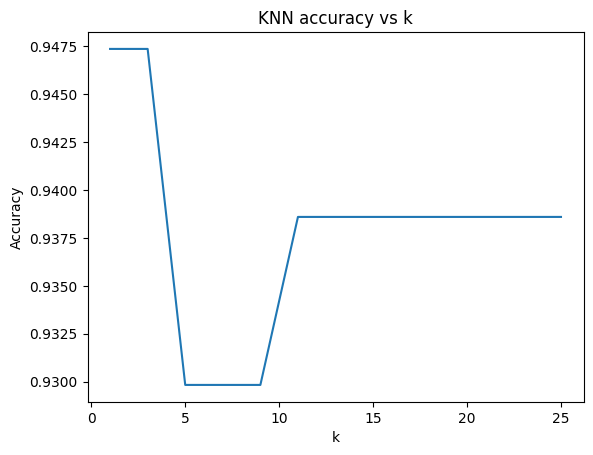

In [13]:
import matplotlib.pyplot as plt
plt.plot(ks, accs)
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("KNN accuracy vs k")
plt.show()

**Note** PyTorch doesn’t have a built-in KNN classifier like sklearn, because KNN has no training/backprop. What we’ll do is implement KNN using PyTorch tensors (so it can run on GPU if you want).
